# Self-Supervised Learning of 3D Human Pose using Multi-view Geometry

Assessment of a tool for 3d joint coordinates from a singe RGB image using neural networks. 

Procedure for adding files in google collab:
https://medium.freecodecamp.org/how-to-transfer-large-files-to-google-colab-and-remote-jupyter-notebooks-26ca252892fa

In [0]:
!git clone https://github.com/mkocabas/EpipolarPose.git

# Setting up the environment

In [2]:
% cd EpipolarPose

/content/EpipolarPose


In [0]:
!mkdir models

In [0]:
!mkdir output

In [5]:
%cd models

/content/EpipolarPose/models


In [0]:
!mkdir h36m

In [7]:
%cd ../

/content/EpipolarPose
/content


In [0]:
!git clone https://github.com/thatbrguy/Dropbox-Uploader.git

In [0]:
cd Dropbox-Uploader

In [0]:
!chmod +x dropbox_uploader.sh

In [0]:
!bash dropbox_uploader.sh

In [0]:
!bash dropbox_uploader.sh download fully_supervised.pth.tar

In [0]:
import shutil
shutil.move("/content/EpipolarPose/Dropbox-Uploader/fully_supervised.pth.tar", "/content/EpipolarPose/models/h36m")

In [0]:
!ls

In [0]:
!bash dropbox_uploader.sh download data.zip

In [0]:
!unzip data.zip

In [0]:
shutil.move("/content/EpipolarPose/Dropbox-Uploader/data", "/content/EpipolarPose")

In [0]:
%cd ..

In [0]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import lib.models as models
from lib.core.config import config
from lib.core.config import update_config
from lib.core.integral_loss import get_joint_location_result
from lib.utils.img_utils import convert_cvimg_to_tensor

from lib.utils.vis import drawskeleton, show3Dpose

In [0]:
print(torch.__version__)

In [0]:
cfg_file = 'experiments/h36m/valid.yaml'
update_config(cfg_file)

torch.backends.cudnn.benchmark = config.CUDNN.BENCHMARK
torch.backends.cudnn.deterministic = config.CUDNN.DETERMINISTIC
torch.backends.cudnn.enabled = config.CUDNN.ENABLED

image_size = config.MODEL.IMAGE_SIZE[0]

In [0]:
# Create model

In [0]:
model = models.pose3d_resnet.get_pose_net(config, is_train=False)
gpus = [int(i) for i in config.GPUS.split(',')]
model = torch.nn.DataParallel(model, device_ids=gpus).cuda()
print('Created model...')

checkpoint = torch.load(config.MODEL.RESUME)
# map_location='cpu'
model.load_state_dict(checkpoint)
model.eval()
print('Loaded pretrained weights...')

# Read and prepocess a sample image

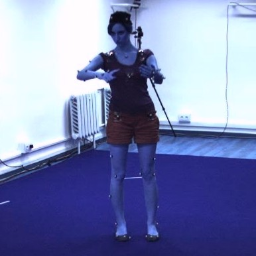

In [33]:
img_path = 'sample_images/0.jpg'
image = cv2.imread(img_path, cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
image = cv2.resize(image, (image_size, image_size))

img_height, img_width, img_channels = image.shape
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_patch = convert_cvimg_to_tensor(image)

from google.colab.patches import cv2_imshow
cv2_imshow(image)

mean = np.array([123.675, 116.280, 103.530])
std = np.array([58.395, 57.120, 57.375])
    
# apply normalization
for n_c in range(img_channels):
    if mean is not None and std is not None:
        img_patch[n_c, :, :] = (img_patch[n_c, :, :] - mean[n_c]) / std[n_c]
cv2_imshow(image)
img_patch = torch.from_numpy(img_patch)

# Inference

In [0]:
preds = model(img_patch[None, ...])
preds = get_joint_location_result(image_size, image_size, preds)[0,:,:3]
preds

# Visualize results

Test on photos taken in the same conditions as training data.

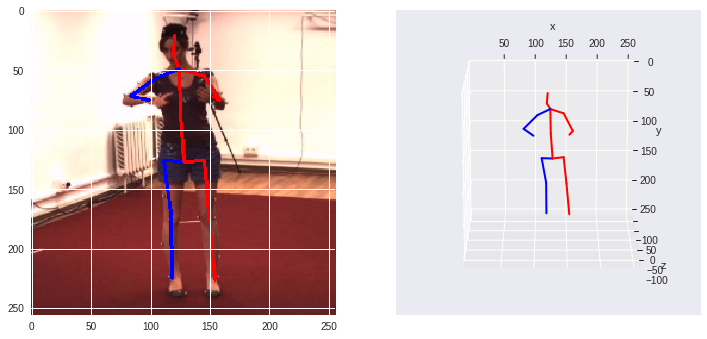

In [110]:
fig = plt.figure(figsize=(12, 7))

ax = fig.add_subplot('121')
drawskeleton(image, preds, thickness=2)
ax.imshow(image)

ax = fig.add_subplot('122', projection='3d', aspect=1)
show3Dpose(preds, ax, radius=128)
ax.view_init(-75, -90)

**Testing on a photo captured in different setting.**

In [0]:
%cd Dropbox-Uploader
!bash dropbox_uploader.sh download ja.jpeg
shutil.move("/content/EpipolarPose/Dropbox-Uploader/ja.jpeg", "/content/EpipolarPose/sample_images")
%cd ..



In [0]:
img_path = 'sample_images/ja.jpeg'
image = cv2.imread(img_path, cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
image = cv2.resize(image, (image_size, image_size))

img_height, img_width, img_channels = image.shape
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_patch = convert_cvimg_to_tensor(image)
meanr = np.mean(image[:,:,0])
stdr = np.std(image[:,:,0])
meang = np.mean(image[:,:,1])
stdg = np.std(image[:,:,1])
meanb = np.mean(image[:,:,2])
stdb = np.std(image[:,:,2])
mean = np.array([meanr, meang, meanb])
std = np.array([stdr, stdg, stdb])
    
# apply normalization
for n_c in range(img_channels):
    if mean is not None and std is not None:
        img_patch[n_c, :, :] = (img_patch[n_c, :, :] - mean[n_c]) / std[n_c]
img_patch = torch.from_numpy(img_patch)

In [0]:
preds = model(img_patch[None, ...])
preds = get_joint_location_result(image_size, image_size, preds)[0,:,:3]
preds

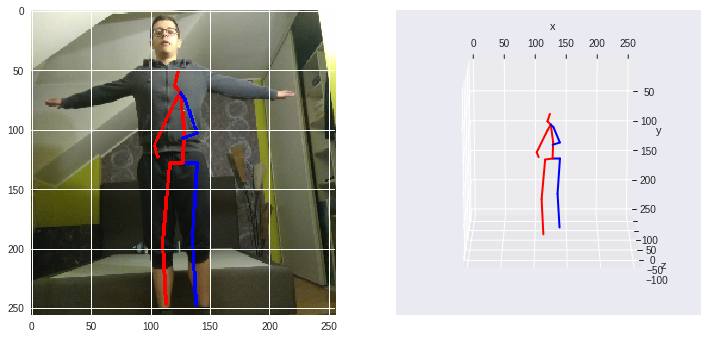

In [44]:
fig = plt.figure(figsize=(12, 7))

ax = fig.add_subplot('121')
drawskeleton(image, preds, thickness=2)
ax.imshow(image)

ax = fig.add_subplot('122', projection='3d', aspect=1)
show3Dpose(preds, ax, radius=128)
ax.view_init(-75, -90)

In [0]:
%cd Dropbox-Uploader
!bash dropbox_uploader.sh download test1.jpg
shutil.move("/content/EpipolarPose/Dropbox-Uploader/test1.jpg", "/content/EpipolarPose/sample_images")
%cd ..

In [0]:
img_path = 'sample_images/test1.jpg'
image = cv2.imread(img_path, cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
image = cv2.resize(image, (image_size, image_size))

img_height, img_width, img_channels = image.shape
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_patch = convert_cvimg_to_tensor(image)
meanr = np.mean(image[:,:,0])
stdr = np.std(image[:,:,0])
meang = np.mean(image[:,:,1])
stdg = np.std(image[:,:,1])
meanb = np.mean(image[:,:,2])
stdb = np.std(image[:,:,2])
mean = np.array([meanr, meang, meanb])
std = np.array([stdr, stdg, stdb])
    
# apply normalization
for n_c in range(img_channels):
    if mean is not None and std is not None:
        img_patch[n_c, :, :] = (img_patch[n_c, :, :] - mean[n_c]) / std[n_c]
img_patch = torch.from_numpy(img_patch)

In [0]:
preds = model(img_patch[None, ...])
preds = get_joint_location_result(image_size, image_size, preds)[0,:,:3]
preds

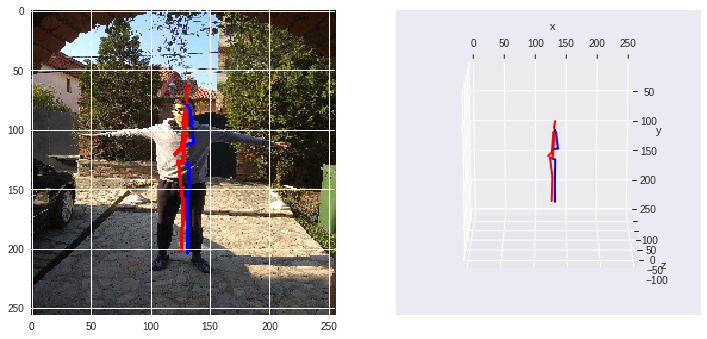

In [48]:
fig = plt.figure(figsize=(12, 7))

ax = fig.add_subplot('121')
drawskeleton(image, preds, thickness=2)
ax.imshow(image)

ax = fig.add_subplot('122', projection='3d', aspect=1)
show3Dpose(preds, ax, radius=128)
ax.view_init(-75, -90)